# Customer Segmentation Analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from math import pi

## Loading Data

In [2]:
# Load the dataset
file_path = 'data/marketing_campaign.csv'
df = pd.read_csv(file_path, sep='\t')
pd.set_option('display.max_columns', None)

# Rename purchase amount columns for clarity
df.rename(columns=lambda x: x.replace('Mnt', 'Amount') if x.startswith('Mnt') else x, inplace=True)

# Display the first few rows of the dataset
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,AmountWines,AmountFruits,AmountMeatProducts,AmountFishProducts,AmountSweetProducts,AmountGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


## Data Preprocessing

In [3]:
# Checking for missing values
missing_values = df.isnull().sum()

# Checking data types and unique values for categorical features
data_types = df.dtypes
unique_values = {col: df[col].unique() for col in df.select_dtypes(include=['object', 'category']).columns}

missing_values, data_types, unique_values

(ID                      0
 Year_Birth              0
 Education               0
 Marital_Status          0
 Income                 24
 Kidhome                 0
 Teenhome                0
 Dt_Customer             0
 Recency                 0
 AmountWines             0
 AmountFruits            0
 AmountMeatProducts      0
 AmountFishProducts      0
 AmountSweetProducts     0
 AmountGoldProds         0
 NumDealsPurchases       0
 NumWebPurchases         0
 NumCatalogPurchases     0
 NumStorePurchases       0
 NumWebVisitsMonth       0
 AcceptedCmp3            0
 AcceptedCmp4            0
 AcceptedCmp5            0
 AcceptedCmp1            0
 AcceptedCmp2            0
 Complain                0
 Z_CostContact           0
 Z_Revenue               0
 Response                0
 dtype: int64,
 ID                       int64
 Year_Birth               int64
 Education               object
 Marital_Status          object
 Income                 float64
 Kidhome                  int64
 Teenhome 

In [4]:
# Dropping rows with 'Absurd', 'Alone', and 'YOLO' in Marital Status before encoding
df = df[~df['Marital_Status'].isin(['Absurd', 'Alone', 'YOLO'])]

# Handling missing values in 'Income'
df['Income'].fillna(df['Income'].median(), inplace=True)

# Converting 'Dt_Customer' to datetime format
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')

# Ensuring that categorical variables are encoded into separate columns (One-hot encoding)
df = pd.get_dummies(df, columns=['Education', 'Marital_Status'], prefix=['education', 'marital_status'], drop_first=True)

# Removing rows with negative income values and capping income at the upper bound
df = df[df['Income'] >= 0]
df = df.drop(df[df['ID'] == 9432].index) # Drop a record with an invalid income

# Calculate Age
df['Age'] = 2024 - df['Year_Birth']
df['Age'] = df['Age'].clip(upper=86)

# Displaying the cleaned dataset's first few rows to confirm the preprocessing steps
df.head()

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,AmountWines,AmountFruits,AmountMeatProducts,AmountFishProducts,AmountSweetProducts,AmountGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,education_Basic,education_Graduation,education_Master,education_PhD,marital_status_Married,marital_status_Single,marital_status_Together,marital_status_Widow,Age
0,5524,1957,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,0,1,0,0,0,1,0,0,67
1,2174,1954,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,0,1,0,0,0,1,0,0,70
2,4141,1965,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,0,1,0,0,0,0,1,0,59
3,6182,1984,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,0,1,0,0,0,0,1,0,40
4,5324,1981,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,0,0,0,1,1,0,0,0,43


## Exploratory Data Analysis

### Demographics

In [5]:
# Setting the seaborn style to 'darkgrid'
sns.set_style("darkgrid")

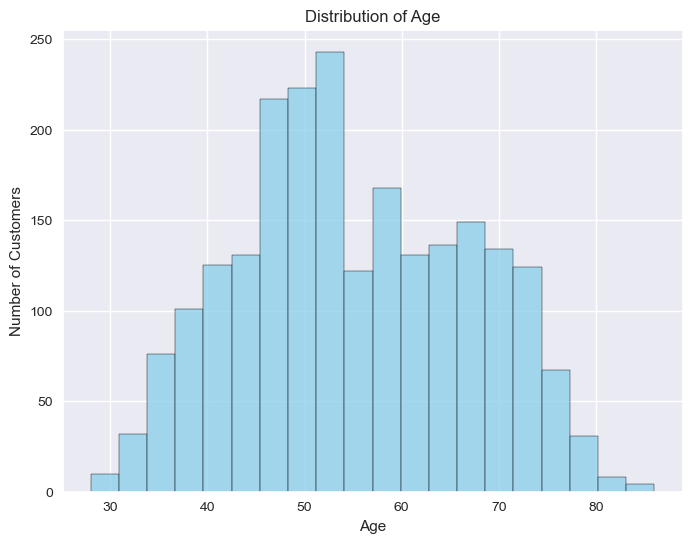

In [6]:
# Plotting Age Distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['Age'], bins=20, kde=False, color='skyblue', edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.show()

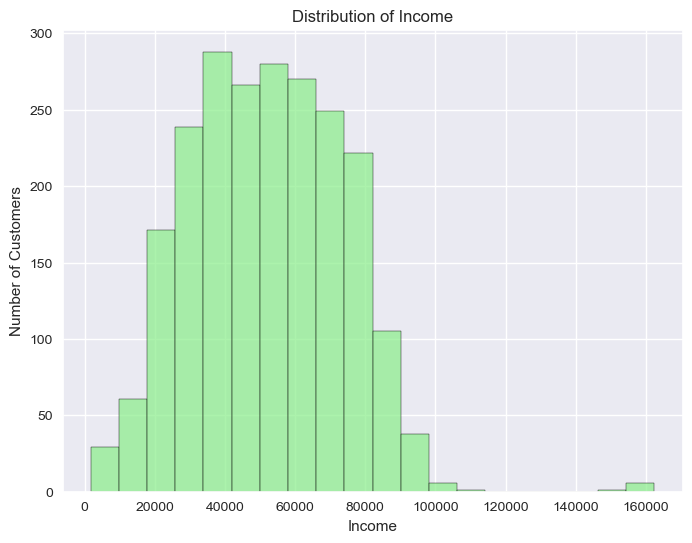

In [7]:
# Plotting Income Distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['Income'], bins=20, kde=False, color='lightgreen', edgecolor='black')
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Number of Customers')
plt.show()

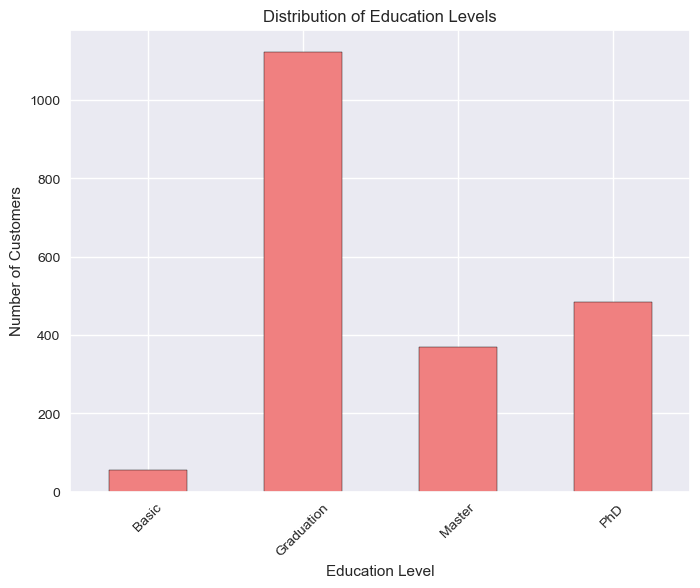

In [8]:
# Distribution of Education Levels
plt.figure(figsize=(8, 6))
education_columns = [col for col in df.columns if 'education_' in col]
education_counts = df[education_columns].sum()
education_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Distribution of Education Levels')
plt.xlabel('Education Level')
plt.ylabel('Number of Customers')
plt.xticks(ticks=range(len(education_columns)), labels=[col.split('_')[1] for col in education_columns], rotation=45)
plt.show()

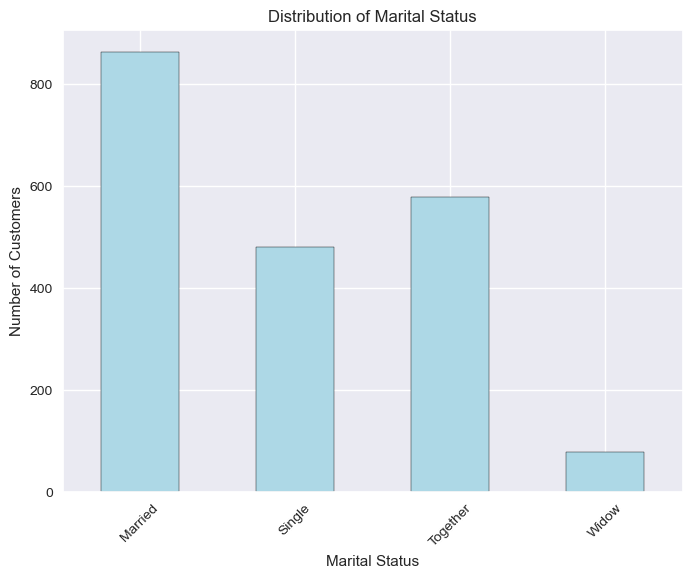

In [9]:
# Distribution of Marital Status
plt.figure(figsize=(8, 6))
marital_status_columns = [col for col in df.columns if 'marital_status_' in col]
marital_status_counts = df[marital_status_columns].sum()
marital_status_counts.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Distribution of Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Number of Customers')
plt.xticks(ticks=range(len(marital_status_columns)), labels=[col.split('_')[2] for col in marital_status_columns], rotation=45)
plt.show()

### Spending

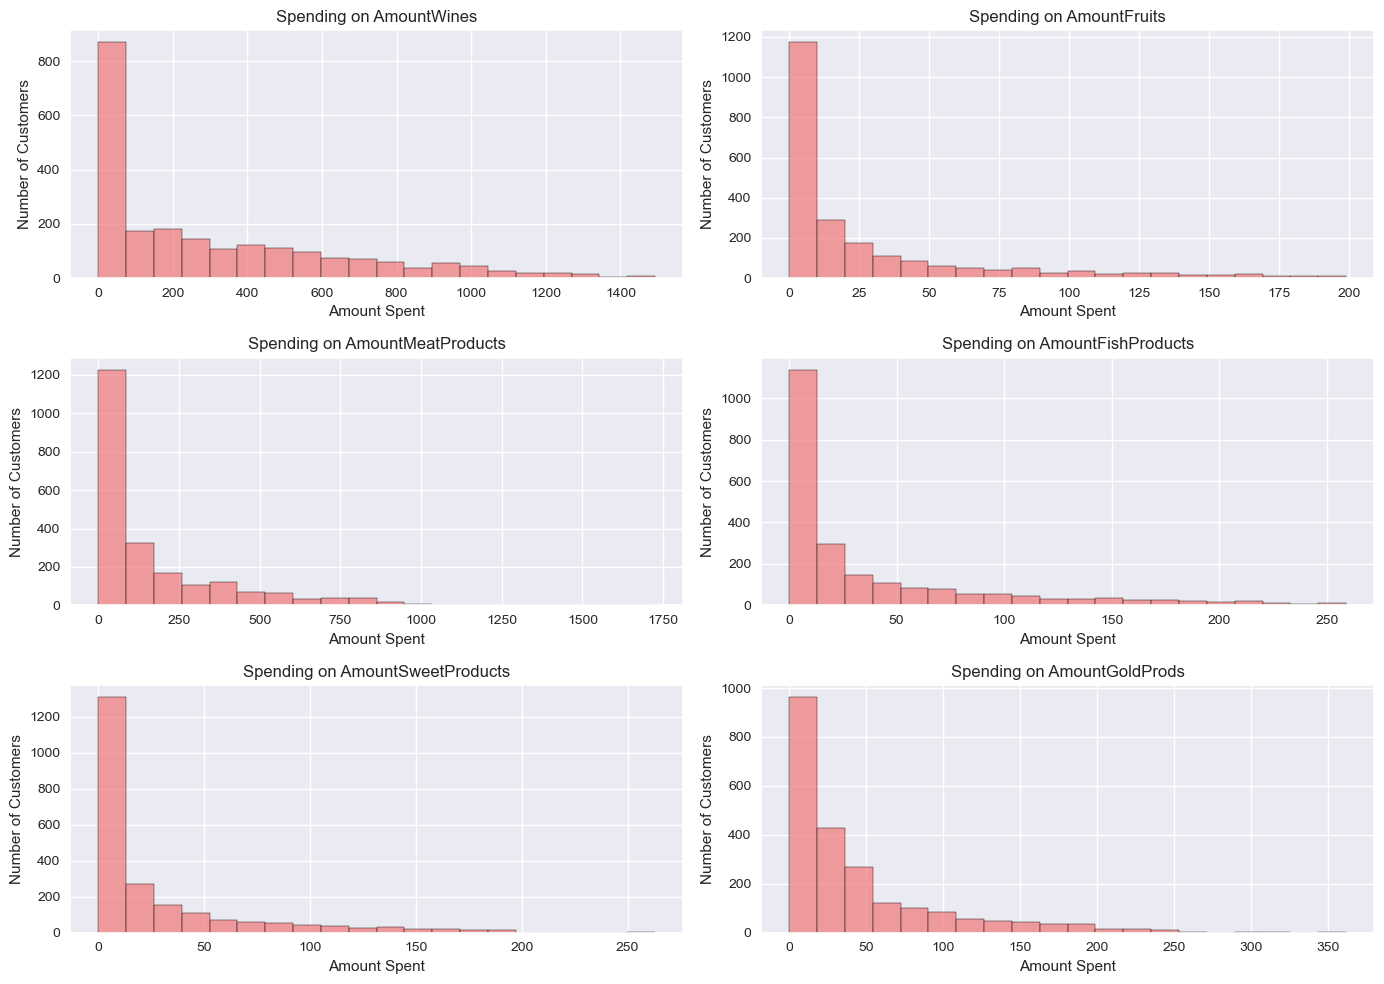

In [10]:
# List of product categories
product_categories = ['AmountWines', 'AmountFruits', 'AmountMeatProducts', 'AmountFishProducts', 'AmountSweetProducts', 'AmountGoldProds']

# Plotting spending behavior on various product categories on the same figure
plt.figure(figsize=(14, 10))

for i, category in enumerate(product_categories, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[category], bins=20, kde=False, color='lightcoral', edgecolor='black')
    plt.title(f'Spending on {category}')
    plt.xlabel('Amount Spent')
    plt.ylabel('Number of Customers')

plt.tight_layout()
plt.show()


### Purchase Channels

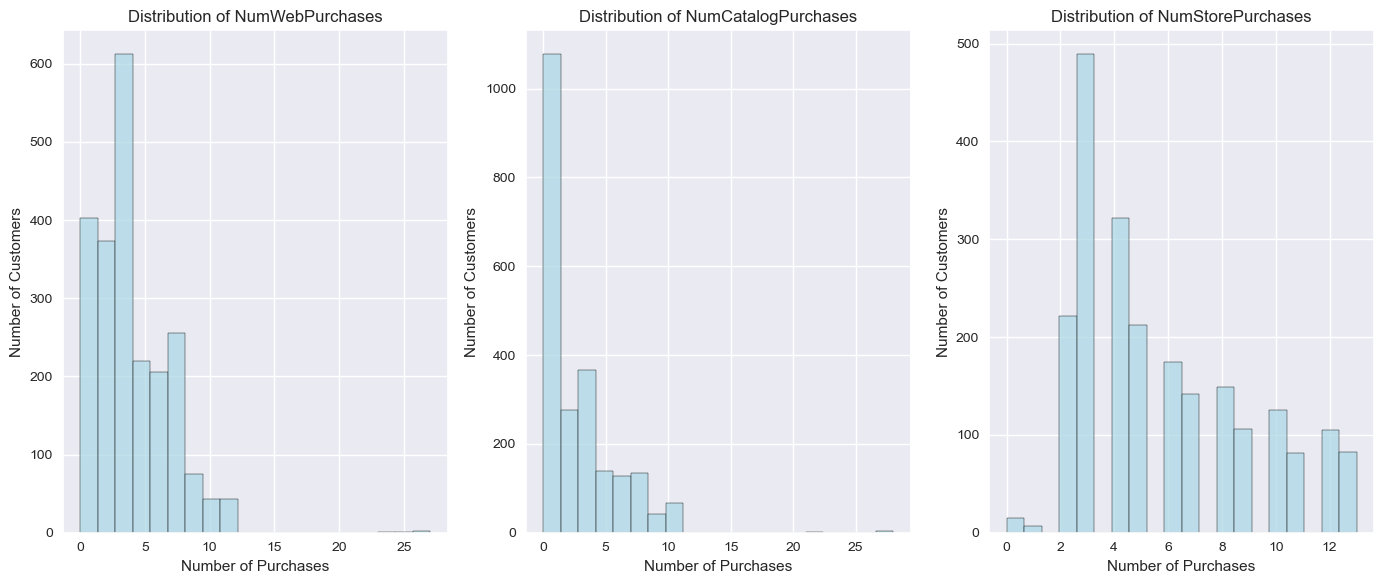

In [11]:
# Analyzing purchase channels: Web, Catalog, and Store purchases

# List of purchase channel columns
purchase_channels = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

# Plotting distribution of purchases across different channels
plt.figure(figsize=(14, 6))

for i, channel in enumerate(purchase_channels, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[channel], bins=20, kde=False, color='lightblue', edgecolor='black')
    plt.title(f'Distribution of {channel}')
    plt.xlabel('Number of Purchases')
    plt.ylabel('Number of Customers')

plt.tight_layout()
plt.show()


### Campaign Response

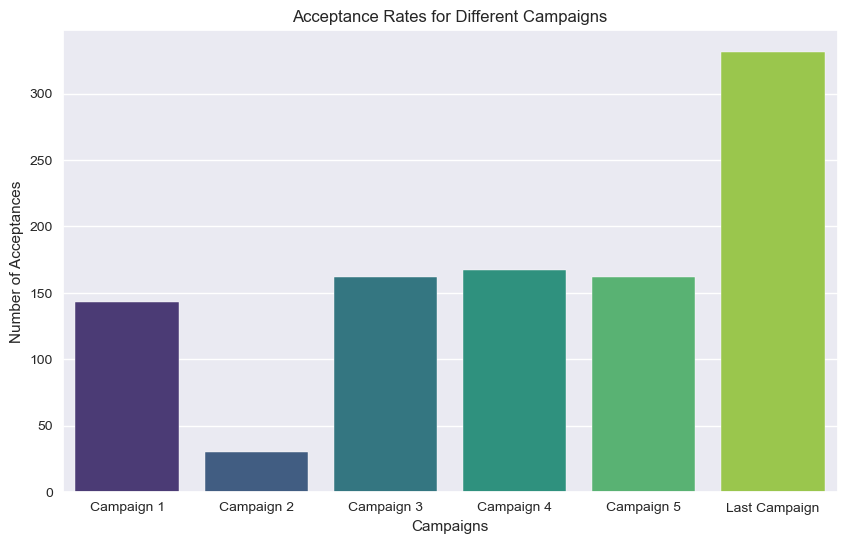

In [12]:
# List of campaign response columns
campaign_columns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
campaign_labels = ['Campaign 1', 'Campaign 2', 'Campaign 3', 'Campaign 4', 'Campaign 5', 'Last Campaign']

# Calculating the acceptance rates for each campaign
campaign_data = df[campaign_columns].sum()

# Plotting the acceptance rates for each campaign
plt.figure(figsize=(10, 6))
sns.barplot(x=campaign_labels, y=campaign_data.values, palette="viridis")
plt.title('Acceptance Rates for Different Campaigns')
plt.xlabel('Campaigns')
plt.ylabel('Number of Acceptances')
plt.show()

## Cluster Analysis

### Segmentation

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


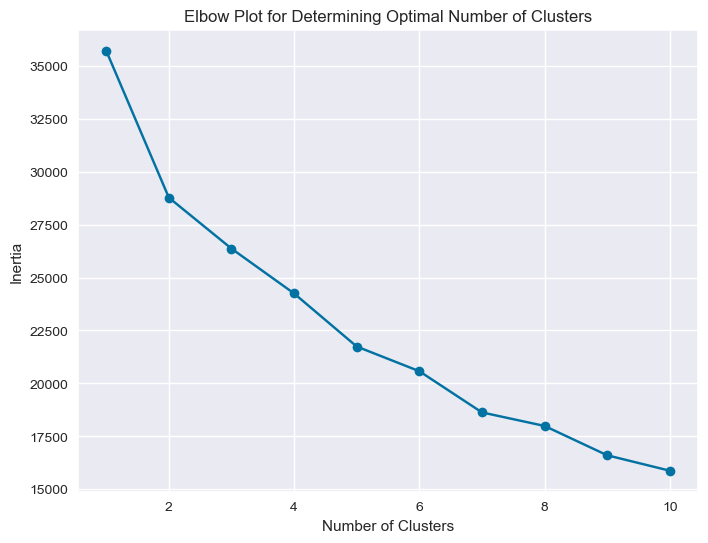

In [13]:
# Selecting relevant features for segmentation
features = ['Age', 'Income', 'AmountWines', 'AmountFruits', 'AmountMeatProducts',
            'AmountFishProducts', 'AmountSweetProducts', 'AmountGoldProds'] + \
           [col for col in df.columns if 'education_' in col] + \
           [col for col in df.columns if 'marital_status_' in col]

# Extracting the features data
X = df[features]

# Normalizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determining the optimal number of clusters using the elbow method
inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Plot for Determining Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [14]:
# Performing K-means clustering with 5 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyzing the characteristics of each cluster
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=features)
cluster_centers_df['Cluster'] = range(1, 3)

# Displaying the cluster centers to understand the characteristics of each cluster
cluster_centers_df


,Age,Income,AmountWines,AmountFruits,AmountMeatProducts,AmountFishProducts,AmountSweetProducts,AmountGoldProds,education_Basic,education_Graduation,education_Master,education_PhD,marital_status_Married,marital_status_Single,marital_status_Together,marital_status_Widow,Cluster
0,54.323003,40648.263774,140.750000,7.313361,44.668733,10.437328,7.222452,24.655647,0.036501,0.476584,0.179063,0.216942,0.396006,0.215565,0.261019,0.026860,1
1,56.712821,73015.848718,608.370513,61.662821,395.239744,87.758974,64.160256,79.774359,0.001282,0.553846,0.138462,0.215385,0.370513,0.214103,0.256410,0.048718,2


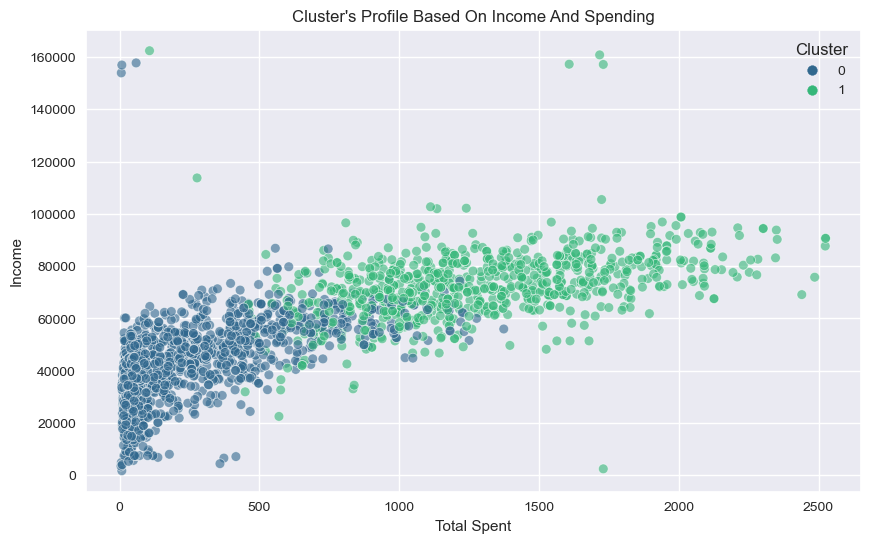

In [15]:
# Creating a scatter plot to visualize clusters based on Income and Total Spent
# Assuming 'TotalSpent' is a calculated column for the total spending
df['TotalSpent'] = df['AmountWines'] + df['AmountFruits'] + df['AmountMeatProducts'] + df['AmountFishProducts'] + df['AmountSweetProducts'] + df['AmountGoldProds']

# Creating the scatter plot
plt.figure(figsize=(10, 6))
pl = sns.scatterplot(data=df, x='TotalSpent', y='Income', hue='Cluster', palette='viridis', alpha=0.6)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.xlabel('Total Spent')
plt.ylabel('Income')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [16]:
# Ensure 'df' has only numeric columns and excludes non-numeric columns like timestamps
numeric_df = df.select_dtypes(include=['number'])

# Extract features and labels
X = numeric_df.drop(columns=['Cluster'])  # Exclude 'Cluster' column if present in the features
y = df['Cluster']  # Cluster labels

# Calculate the silhouette score
silhouette_avg = silhouette_score(X, y)
print(f'Silhouette Score: {silhouette_avg}')

# Calculate the Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(X, y)
print(f'Calinski-Harabasz Index: {calinski_harabasz}')

# Calculate the Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X, y)
print(f'Davies-Bouldin Index: {davies_bouldin}')

Silhouette Score: 0.4303628272179567
Calinski-Harabasz Index: 2297.901822209848
Davies-Bouldin Index: 0.718969750881457


In [17]:
# Assuming 'Cluster' is the column with the main cluster labels and 'df' is your DataFrame
cluster_0_data = df[df['Cluster'] == 0]
cluster_1_data = df[df['Cluster'] == 1]

# Convert datetime columns if necessary, or drop them if they are not useful for clustering
# For example, converting 'Dt_Customer' to the number of days since a specific date
df['Days_Since_Enrollment'] = (pd.Timestamp('now') - pd.to_datetime(df['Dt_Customer'])).dt.days

# Drop non-numeric columns and the original datetime column
df_numeric = df.drop(columns=['Cluster', 'Dt_Customer'])  # Add other non-numeric columns if necessary

# Filter only numeric data
numeric_columns = df_numeric.select_dtypes(include=['number']).columns
X_cluster_0 = df[df['Cluster'] == 0][numeric_columns]
X_cluster_1 = df[df['Cluster'] == 1][numeric_columns]

# Apply K-Means to find sub-clusters within cluster 0
kmeans_cluster_0 = KMeans(n_clusters=2, random_state=42).fit(X_cluster_0)
df.loc[df['Cluster'] == 0, 'Subcluster'] = kmeans_cluster_0.labels_

# Apply K-Means to find sub-clusters within cluster 1
kmeans_cluster_1 = KMeans(n_clusters=2, random_state=42).fit(X_cluster_1)
df.loc[df['Cluster'] == 1, 'Subcluster'] = kmeans_cluster_1.labels_

In [18]:
# For sub-clusters within the original cluster 0
silhouette_avg_0 = silhouette_score(X_cluster_0, df[df['Cluster'] == 0]['Subcluster'])
calinski_harabasz_0 = calinski_harabasz_score(X_cluster_0, df[df['Cluster'] == 0]['Subcluster'])
davies_bouldin_0 = davies_bouldin_score(X_cluster_0, df[df['Cluster'] == 0]['Subcluster'])

print(f'Sub-Cluster 0 - Silhouette Score: {silhouette_avg_0}')
print(f'Sub-Cluster 0 - Calinski-Harabasz Index: {calinski_harabasz_0}')
print(f'Sub-Cluster 0 - Davies-Bouldin Index: {davies_bouldin_0}')

# For sub-clusters within the original cluster 1
silhouette_avg_1 = silhouette_score(X_cluster_1, df[df['Cluster'] == 1]['Subcluster'])
calinski_harabasz_1 = calinski_harabasz_score(X_cluster_1, df[df['Cluster'] == 1]['Subcluster'])
davies_bouldin_1 = davies_bouldin_score(X_cluster_1, df[df['Cluster'] == 1]['Subcluster'])

print(f'Sub-Cluster 1 - Silhouette Score: {silhouette_avg_1}')
print(f'Sub-Cluster 1 - Calinski-Harabasz Index: {calinski_harabasz_1}')
print(f'Sub-Cluster 1 - Davies-Bouldin Index: {davies_bouldin_1}')

Sub-Cluster 0 - Silhouette Score: 0.5255779363538116
Sub-Cluster 0 - Calinski-Harabasz Index: 2170.9155462471986
Sub-Cluster 0 - Davies-Bouldin Index: 0.6508987002199438
Sub-Cluster 1 - Silhouette Score: 0.46130052771548885
Sub-Cluster 1 - Calinski-Harabasz Index: 693.6154191301382
Sub-Cluster 1 - Davies-Bouldin Index: 0.760878426497644


In [19]:
# Ensure 'Total_Spent' is calculated
if 'Total_Spent' not in df.columns:
    df['Total_Spent'] = df[['AmountWines', 'AmountFruits', 'AmountMeatProducts', 'AmountFishProducts', 'AmountSweetProducts', 'AmountGoldProds']].sum(axis=1)

# Convert datetime columns if necessary, or drop them if they are not useful for clustering
if 'Dt_Customer' in df.columns:
    df['Days_Since_Enrollment'] = (pd.Timestamp('now') - pd.to_datetime(df['Dt_Customer'])).dt.days

# Drop non-numeric columns and the original datetime column
df_numeric = df.select_dtypes(include=[np.number]).drop(columns=['Cluster', 'Subcluster'], errors='ignore')

In [20]:
# Subclustering Process
for main_cluster in df['Cluster'].unique():
    main_cluster_data = df[df['Cluster'] == main_cluster]
    if main_cluster_data.empty:
        continue
    
    X = main_cluster_data[df_numeric.columns]
    kmeans = KMeans(n_clusters=2, random_state=42)
    subcluster_labels = kmeans.fit_predict(X)
    df.loc[df['Cluster'] == main_cluster, 'Subcluster'] = subcluster_labels + main_cluster * 2

# Verify that Subcluster column has a wider range of labels now
print(f"Subclusters: {df['Subcluster'].unique()}")

Subclusters: [2. 1. 0. 3.]


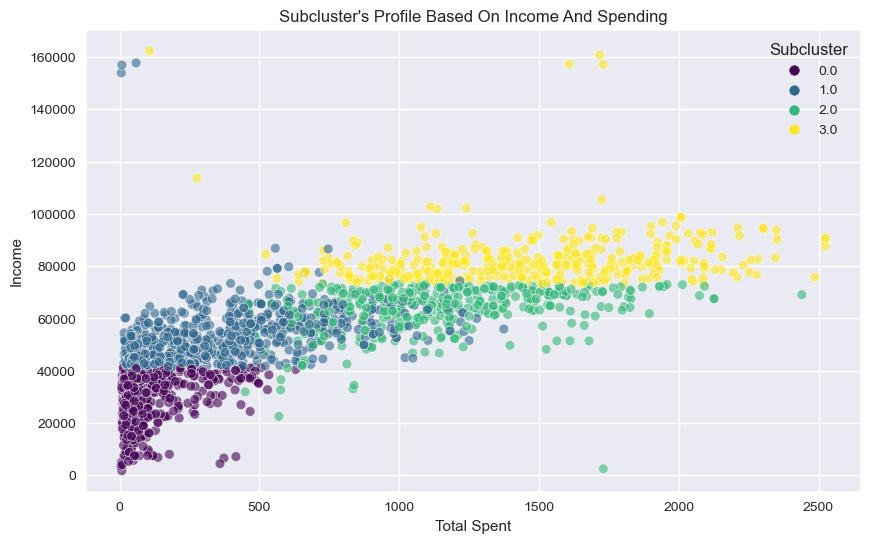

In [21]:
# Creating a scatter plot to visualize subclusters based on Income and Total Spent
plt.figure(figsize=(10, 6))
pl = sns.scatterplot(data=df, x='TotalSpent', y='Income', hue='Subcluster', palette='viridis', alpha=0.6)
pl.set_title("Subcluster's Profile Based On Income And Spending")
plt.xlabel('Total Spent')
plt.ylabel('Income')
plt.legend(title='Subcluster')
plt.grid(True)
plt.show()

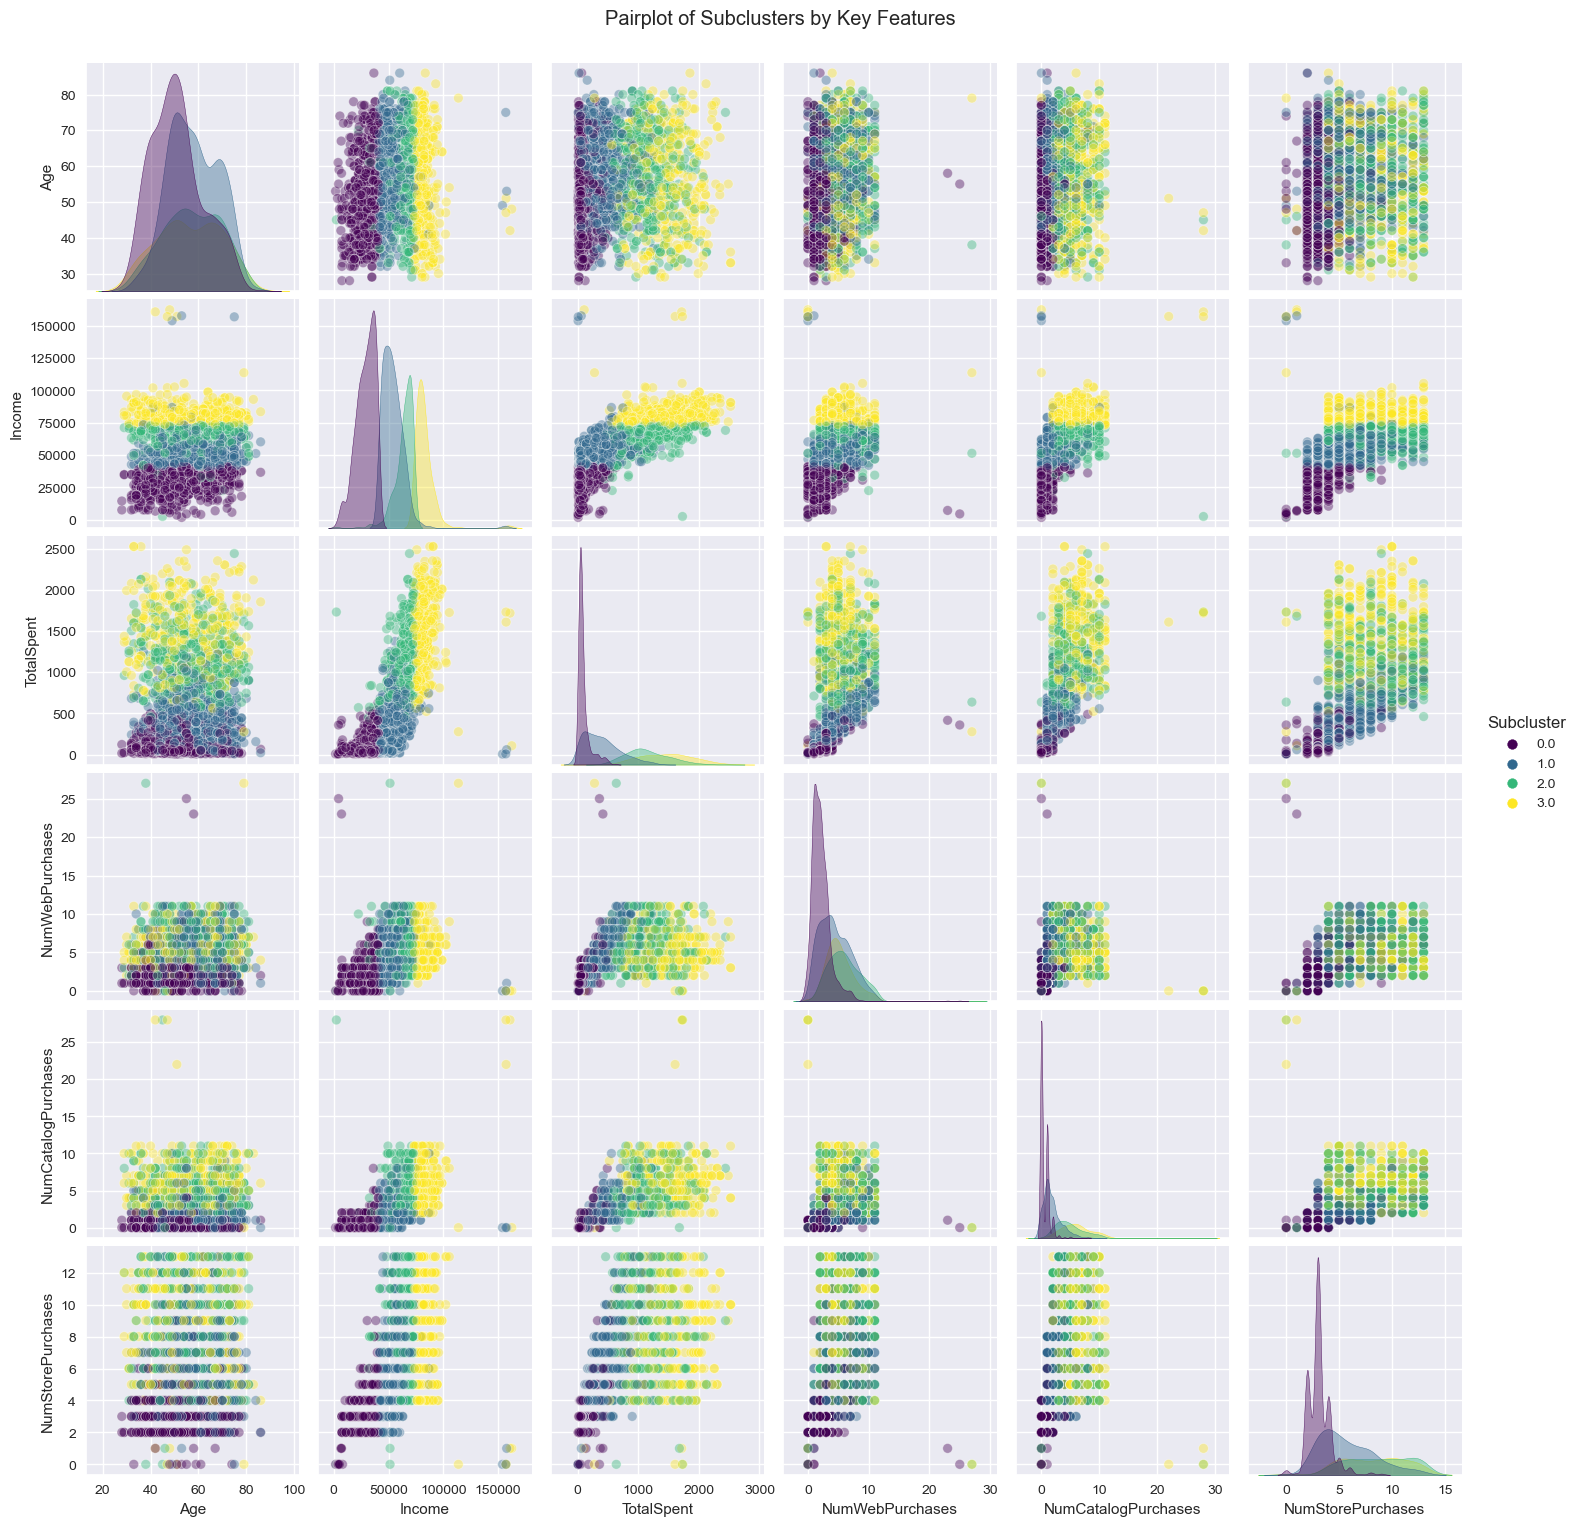

In [22]:
# Ensure 'TotalSpent' is calculated if not already done
if 'TotalSpent' not in df.columns:
    df['TotalSpent'] = df[['AmountWines', 'AmountFruits', 'AmountMeatProducts', 'AmountFishProducts', 'AmountSweetProducts', 'AmountGoldProds']].sum(axis=1)

# Selecting key features for the pairplot
pairplot_features = ['Age', 'Income', 'TotalSpent', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'Subcluster']

# Creating the pairplot
sns.pairplot(df[pairplot_features], hue='Subcluster', palette='viridis', 
             plot_kws={'alpha':0.4}, diag_kws={'alpha':0.4})
plt.suptitle('Pairplot of Subclusters by Key Features', y=1.02)
plt.show()

### Cluster Analysis

In [59]:
# Adjusted profiling with rounding purchases to two decimal points
subcluster_profiles = []

# Assuming 'Children', 'Complain', and discount-related columns exist, along with marital status and education columns
marital_status_cols = ['marital_status_Married', 'marital_status_Single', 'marital_status_Together', 'marital_status_Widow']
education_cols = ['education_Basic', 'education_Graduation', 'education_Master', 'education_PhD']
discount_cols = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

# Assigning meaningful names to each subcluster
subcluster_names = {
    0.0: 'Working Class',
    1.0: 'Emerging Professionals',
    2.0: 'Value-Oriented Professionals',
    3.0: 'High-Income Luxury Seekers'
}

for subcluster in df['Subcluster'].unique():
    # Filter data for the current subcluster
    subcluster_data = df[df['Subcluster'] == subcluster]
    
    # Demographic Profiling
    age_summary = subcluster_data['Age'].describe()
    income_summary = subcluster_data['Income'].describe()
    
    # Behavioral Profiling
    total_spent_summary = subcluster_data['Total_Spent'].describe()
    purchasing_patterns = subcluster_data[['AmountWines', 'AmountFruits', 'AmountMeatProducts', 'AmountFishProducts', 'AmountSweetProducts', 'AmountGoldProds']].mean()
    channel_preferences = subcluster_data[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].mean()
    
    # Additional Features
    children_avg = subcluster_data['Kidhome'].mean() + subcluster_data['Teenhome'].mean()
    complaints_percentage = subcluster_data['Complain'].mean() * 100
    marital_status_percentage = (subcluster_data[marital_status_cols].mean() * 100).to_dict()
    education_percentage = (subcluster_data[education_cols].mean() * 100).to_dict()
    
    # Calculate overall discount percentage
    total_discount_purchases = subcluster_data[discount_cols].sum(axis=1).sum()
    total_spent = subcluster_data['Total_Spent'].sum()
    discounts_percentage = (total_discount_purchases / total_spent) * 100 if total_spent != 0 else 0
    
    # Creating a profile dictionary for the current subcluster with formatted values
    profile = {
        'Subcluster': subcluster,
        'Name': subcluster_names.get(subcluster, 'Unknown'),
        'Age_Mean': round(age_summary['mean']),
        'Age_Median': age_summary['50%'],
        'Age_Q1': age_summary['25%'],
        'Age_Q3': age_summary['75%'],
        'Income_Mean': f"${income_summary['mean']:,.0f}",
        'Income_Median': f"${income_summary['50%']:,.0f}",
        'Income_Q1': f"${income_summary['25%']:,.0f}",
        'Income_Q3': f"${income_summary['75%']:,.0f}",
        'Total_Spent_Mean': f"${total_spent_summary['mean']:,.0f}",
        'Total_Spent_Median': f"${total_spent_summary['50%']:,.0f}",
        'Purchases_Wines': round(purchasing_patterns['AmountWines'], 2),
        'Purchases_Fruits': round(purchasing_patterns['AmountFruits'], 2),
        'Purchases_Meat': round(purchasing_patterns['AmountMeatProducts'], 2),
        'Purchases_Fish': round(purchasing_patterns['AmountFishProducts'], 2),
        'Purchases_Sweets': round(purchasing_patterns['AmountSweetProducts'], 2),
        'Purchases_Gold': round(purchasing_patterns['AmountGoldProds'], 2),
        'NumWebPurchases': f"{channel_preferences['NumWebPurchases']:.1f}",
        'NumCatalogPurchases': f"{channel_preferences['NumCatalogPurchases']:.1f}",
        'NumStorePurchases': f"{channel_preferences['NumStorePurchases']:.1f}",
        'Children_Avg': f"{children_avg:.2f}",
        'Complaints_%': f"{complaints_percentage:.2f}%",
        'Discounts_%': f"{discounts_percentage:.2f}%"
    }
    
    # Adding formatted marital status and education percentages
    profile.update({f"Marital_Status_{status}_%": f"{percentage:.2f}%" for status, percentage in marital_status_percentage.items()})
    profile.update({f"Education_{edu_level}_%": f"{percentage:.2f}%" for edu_level, percentage in education_percentage.items()})
    
    # Append the profile data to the list
    subcluster_profiles.append(profile)

# Convert the list of profiles into a DataFrame for better visualization
subcluster_profiles_df = pd.DataFrame(subcluster_profiles)

# Display the profiles in a table format
subcluster_profiles_df

,Subcluster,Name,Age_Mean,Age_Median,Age_Q1,Age_Q3,Income_Mean,Income_Median,Income_Q1,Income_Q3,Total_Spent_Mean,Total_Spent_Median,Purchases_Wines,Purchases_Fruits,Purchases_Meat,Purchases_Fish,Purchases_Sweets,Purchases_Gold,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,Children_Avg,Complaints_%,Discounts_%,Marital_Status_marital_status_Married_%,Marital_Status_marital_status_Single_%,Marital_Status_marital_status_Together_%,Marital_Status_marital_status_Widow_%,Education_education_Basic_%,Education_education_Graduation_%,Education_education_Master_%,Education_education_PhD_%
0,2.0,Value-Oriented Professionals,57,57.0,48.0,67.00,"$63,965","$65,832","$60,924","$70,069","$1,143","$1,092",548.27,57.24,310.56,81.28,58.93,86.68,6.0,4.9,8.7,0.60,0.50%,1.94%,36.25%,20.25%,24.75%,6.00%,0.25%,57.75%,11.25%,21.25%
1,1.0,Emerging Professionals,58,57.5,50.0,67.00,"$53,705","$51,742","$46,380","$58,654",$393,$338,260.00,9.53,68.91,12.88,9.11,32.51,4.5,1.8,5.7,1.30,0.58%,3.81%,40.00%,19.57%,25.80%,3.62%,0.00%,43.91%,21.59%,27.39%
2,0.0,Working Class,51,50.0,43.0,57.00,"$28,825","$30,360","$23,007","$35,889",$92,$57,32.77,5.30,22.72,8.22,5.52,17.54,2.1,0.5,3.1,1.14,1.71%,8.54%,39.24%,23.36%,26.38%,1.84%,6.96%,51.05%,14.57%,16.54%
3,3.0,High-Income Luxury Seekers,56,55.0,46.0,66.25,"$82,543","$80,690","$77,042","$84,842","$1,459","$1,454",671.64,66.32,484.38,94.58,69.67,72.51,5.3,6.2,8.3,0.29,0.53%,1.44%,37.89%,22.63%,26.58%,3.68%,0.00%,52.89%,16.58%,21.84%


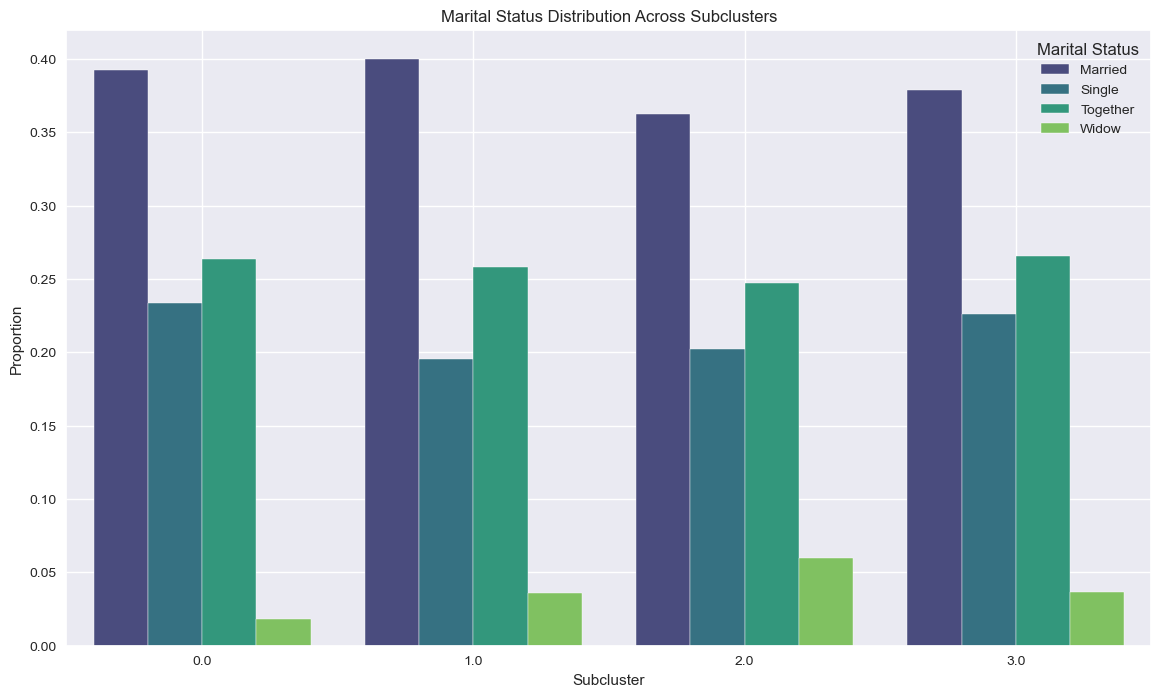

In [60]:
# Preparing the data for plotting
marital_status_df = pd.DataFrame({
    'Subcluster': df['Subcluster'],
    'Married': df['marital_status_Married'],
    'Single': df['marital_status_Single'],
    'Together': df['marital_status_Together'],
    'Widow': df['marital_status_Widow']
})

# Melting the dataframe for seaborn
marital_status_df = marital_status_df.melt(id_vars='Subcluster', var_name='Marital_Status', value_name='Proportion')

# Plotting the side-by-side bar chart without error bars
plt.figure(figsize=(14, 8))
sns.barplot(data=marital_status_df, x='Subcluster', y='Proportion', hue='Marital_Status', palette='viridis', ci=None)
plt.title('Marital Status Distribution Across Subclusters')
plt.xlabel('Subcluster')
plt.ylabel('Proportion')
plt.legend(title='Marital Status')
plt.grid(True)
plt.show()

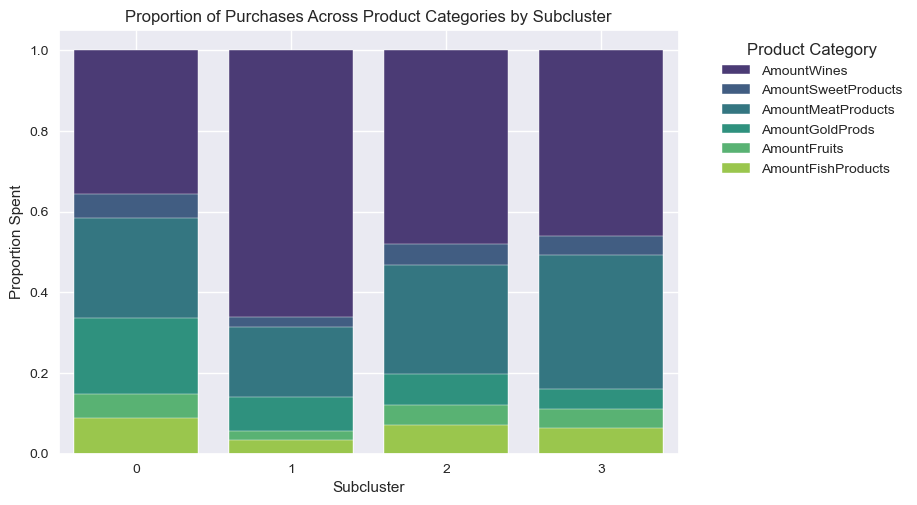

In [61]:
# Aggregating the data to get average spending in each category per subcluster
average_spending = df.groupby('Subcluster').agg({
    'AmountWines': 'mean',
    'AmountFruits': 'mean',
    'AmountMeatProducts': 'mean',
    'AmountFishProducts': 'mean',
    'AmountSweetProducts': 'mean',
    'AmountGoldProds': 'mean'
}).reset_index()

# Melting the DataFrame for seaborn
average_spending_melted = average_spending.melt(id_vars='Subcluster', var_name='Product_Category', value_name='Average_Spent')

# Calculate the proportion of spending for each product category within each subcluster
average_spending_melted['Proportion_Spent'] = average_spending_melted.groupby('Subcluster')['Average_Spent'].transform(lambda x: x / x.sum())

# Create a distribution DataFrame using crosstab
distribution = pd.crosstab(average_spending_melted.Subcluster, average_spending_melted.Product_Category, values=average_spending_melted.Proportion_Spent, aggfunc='mean', normalize='index').fillna(0)

# Define the viridis color palette
viridis_palette = sns.color_palette("viridis", len(distribution.columns))

# Plotting the cumsum with reverse hue order and viridis color palette
sns.barplot(data=distribution.cumsum(axis=1).stack().reset_index(name='Dist'),
            x='Subcluster', y='Dist', hue='Product_Category',
            hue_order=distribution.columns[::-1], dodge=False, palette=viridis_palette)
plt.title('Proportion of Purchases Across Product Categories by Subcluster')
plt.xlabel('Subcluster')
plt.ylabel('Proportion Spent')
plt.xticks(ticks=range(len(distribution)), labels=distribution.index.astype(int))
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

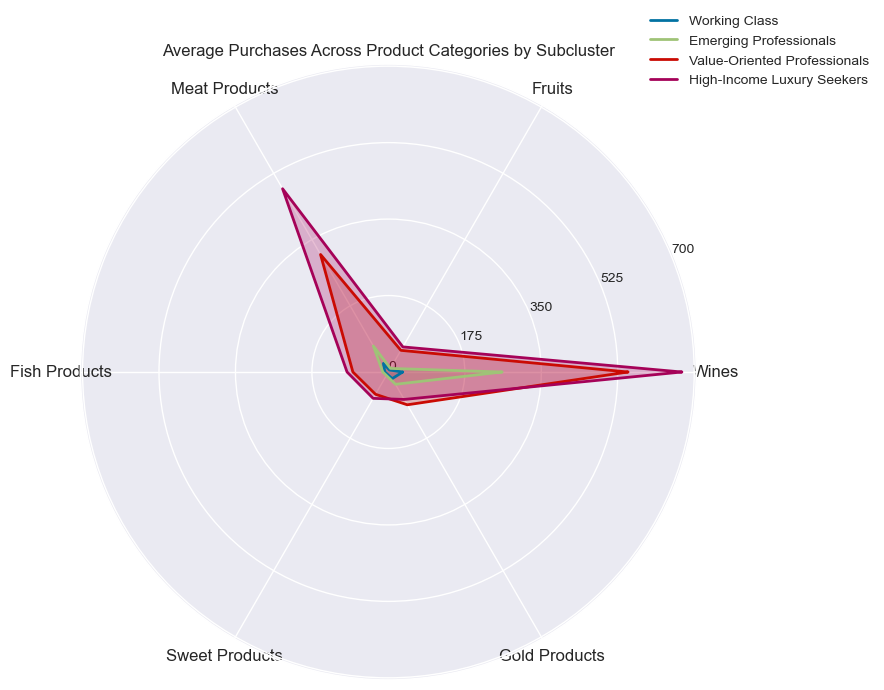

In [62]:
# Categories for the radar chart without 'Amount' prefix
categories = ['Wines', 'Fruits', 'Meat Products', 'Fish Products', 'Sweet Products', 'Gold Products']
N = len(categories)

# Calculating angles for each category axis
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Complete the loop

# Define the appropriate scaling for the data
max_value = average_spending[['AmountWines', 'AmountFruits', 'AmountMeatProducts', 'AmountFishProducts', 'AmountSweetProducts', 'AmountGoldProds']].max().max()
max_range = int(max_value // 100 + 1) * 100  # Round up to the nearest hundred for a nice axis range

# Initialize the radar chart with a zoomed-in scale
plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)

# Define a color palette
colors = ['b', 'g', 'r', 'm']

# Plotting data for each subcluster
for i in range(len(average_spending)):
    values = average_spending.loc[i, ['AmountWines', 'AmountFruits', 'AmountMeatProducts', 'AmountFishProducts', 'AmountSweetProducts', 'AmountGoldProds']].tolist()
    values += values[:1]  # Repeat the first value to close the circle
    subcluster_label = subcluster_names.get(average_spending["Subcluster"][i], f'Subcluster {int(average_spending["Subcluster"][i])}')
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=subcluster_label, color=colors[i])
    ax.fill(angles, values, color=colors[i], alpha=0.25)

# Add labels for each category without the 'Amount' prefix
plt.xticks(angles[:-1], categories, size=12)
plt.yticks(np.linspace(0, max_range, num=5), [f"{int(x)}" for x in np.linspace(0, max_range, num=5)], size=10)

# Title and legend
plt.title('Average Purchases Across Product Categories by Subcluster')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Show the plot
plt.show()

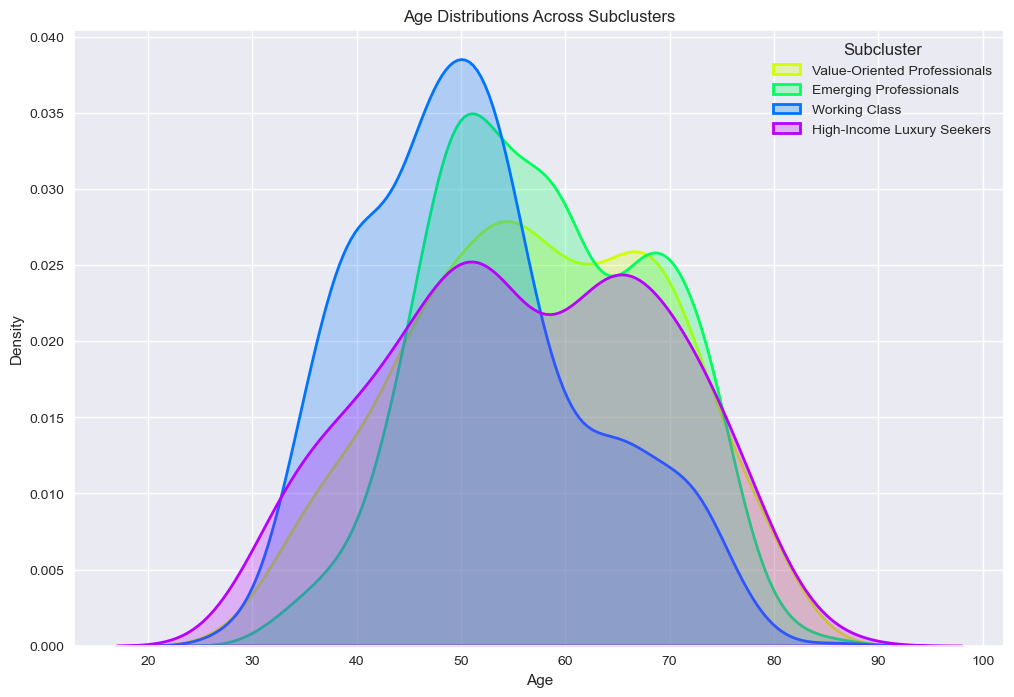

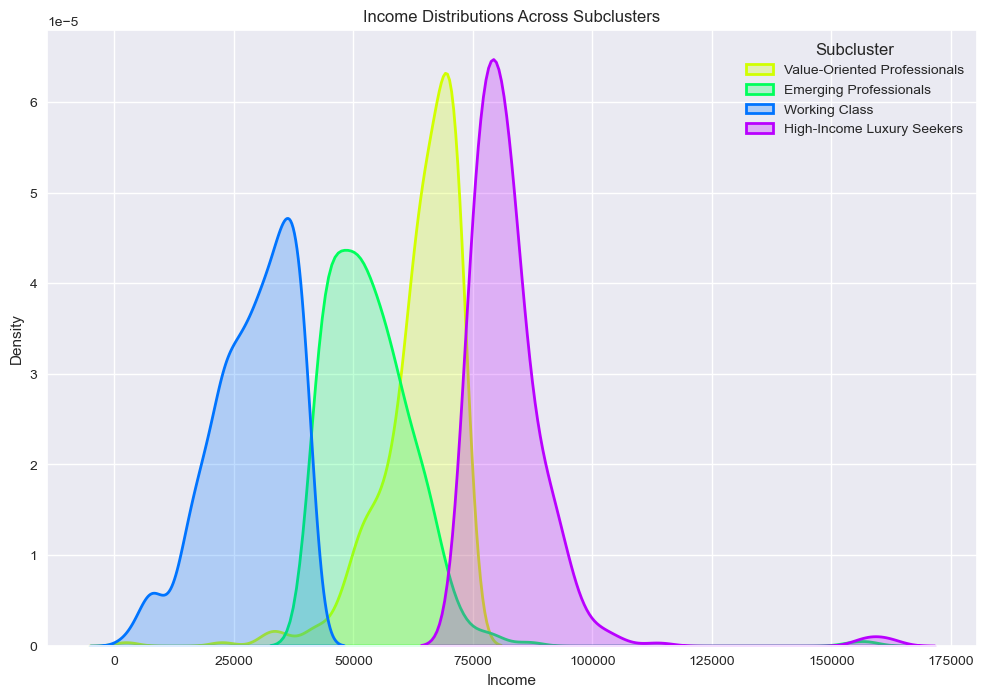

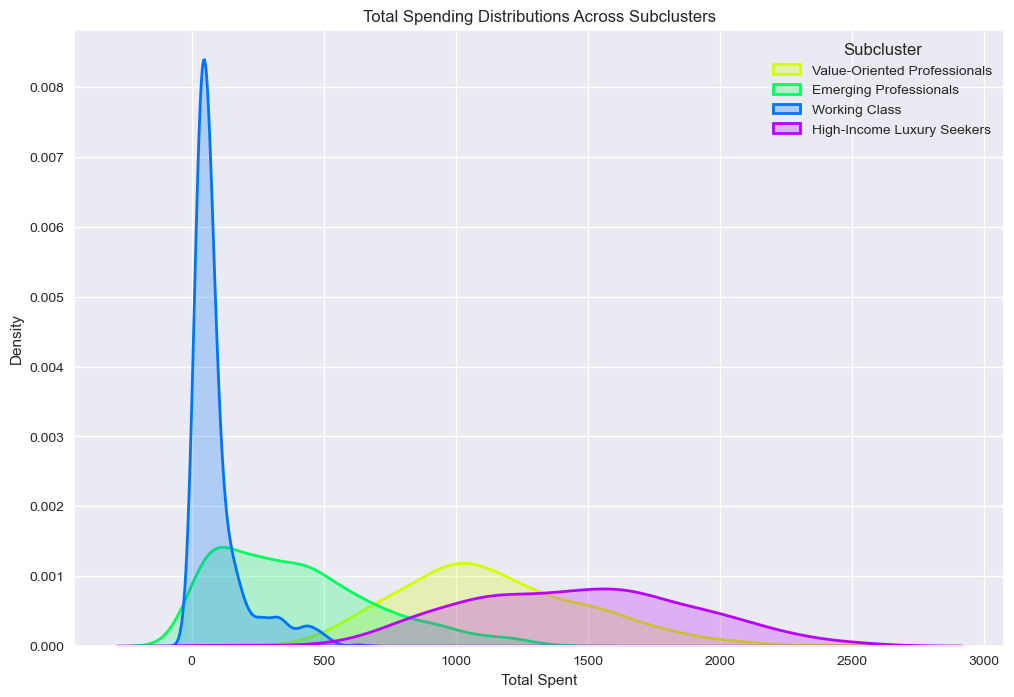

In [63]:
# Define the adjusted names for the subclusters
subcluster_names = {
    0: 'Working Class',
    1: 'Emerging Professionals',
    2: 'Value-Oriented Professionals',
    3: 'High-Income Luxury Seekers'
}

# Function to plot KDE plots for Age for all subclusters with custom names and colors
def plot_age_kde(df, subcluster_names):
    plt.figure(figsize=(12, 8))
    colors = sns.color_palette("hsv", len(subcluster_names))
    for subcluster, color in zip(df['Subcluster'].unique(), colors):
        subcluster_data = df[df['Subcluster'] == subcluster]
        sns.kdeplot(subcluster_data['Age'], label=subcluster_names[subcluster], color=color, shade=True, linewidth=2)
    plt.title('Age Distributions Across Subclusters')
    plt.xlabel('Age')
    plt.ylabel('Density')
    plt.legend(title='Subcluster')
    plt.grid(True)
    plt.show()

# Function to plot KDE plots for Income for all subclusters with custom names and colors
def plot_income_kde(df, subcluster_names):
    plt.figure(figsize=(12, 8))
    colors = sns.color_palette("hsv", len(subcluster_names))
    for subcluster, color in zip(df['Subcluster'].unique(), colors):
        subcluster_data = df[df['Subcluster'] == subcluster]
        sns.kdeplot(subcluster_data['Income'], label=subcluster_names[subcluster], color=color, shade=True, linewidth=2)
    plt.title('Income Distributions Across Subclusters')
    plt.xlabel('Income')
    plt.ylabel('Density')
    plt.legend(title='Subcluster')
    plt.grid(True)
    plt.show()

    # Function to plot KDE plots for Total Spending for all subclusters with custom names and colors
def plot_total_spent_kde(df, subcluster_names):
    plt.figure(figsize=(12, 8))
    colors = sns.color_palette("hsv", len(subcluster_names))
    for subcluster, color in zip(df['Subcluster'].unique(), colors):
        subcluster_data = df[df['Subcluster'] == subcluster]
        sns.kdeplot(subcluster_data['Total_Spent'], label=subcluster_names[subcluster], color=color, shade=True, linewidth=2)
    plt.title('Total Spending Distributions Across Subclusters')
    plt.xlabel('Total Spent')
    plt.ylabel('Density')
    plt.legend(title='Subcluster')
    plt.grid(True)
    plt.show()

# Plotting KDE plots for Age, Income, and Total Spending
plot_age_kde(df, subcluster_names)
plot_income_kde(df, subcluster_names)
plot_total_spent_kde(df, subcluster_names)


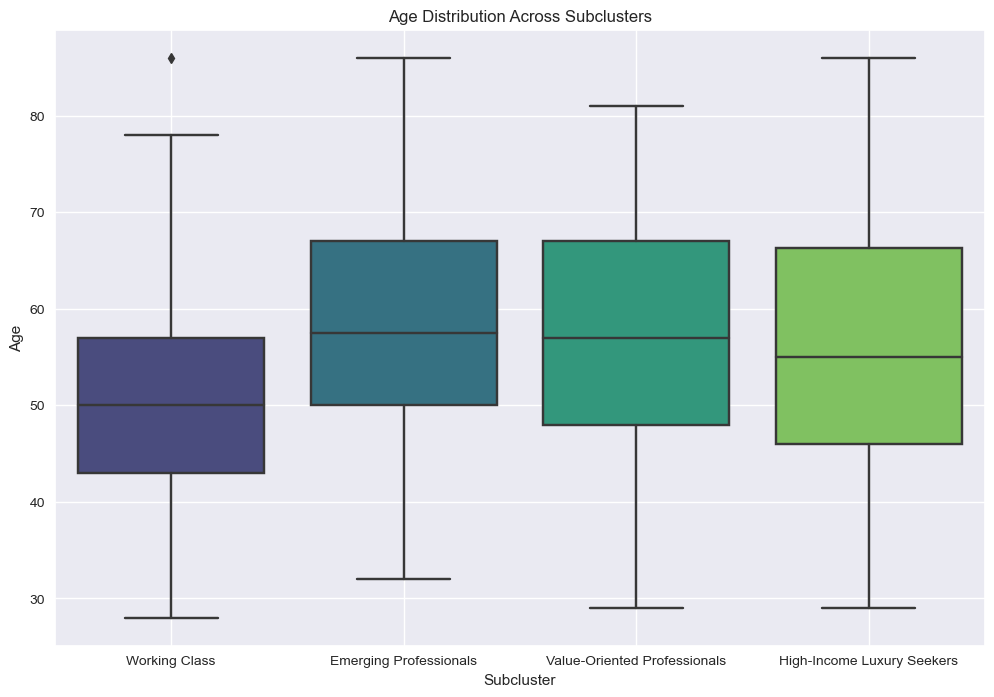

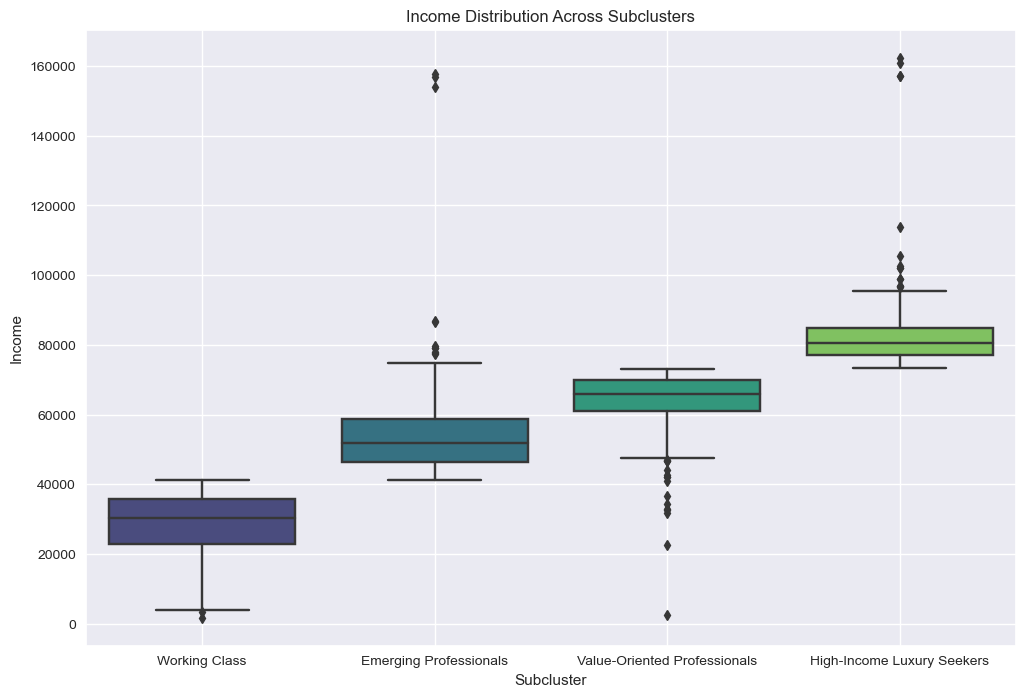

In [64]:
# Define the adjusted names for the subclusters
subcluster_names = {
    0: 'Working Class',
    1: 'Emerging Professionals',
    2: 'Value-Oriented Professionals',
    3: 'High-Income Luxury Seekers'
}

# Function to plot box plots for Age for all subclusters
def plot_age_boxplot(df, subcluster_names):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Subcluster', y='Age', data=df, palette='viridis')
    plt.title('Age Distribution Across Subclusters')
    plt.xlabel('Subcluster')
    plt.ylabel('Age')
    plt.xticks(ticks=[0, 1, 2, 3], labels=[subcluster_names[0], subcluster_names[1], subcluster_names[2], subcluster_names[3]])
    plt.grid(True)
    plt.show()

# Function to plot box plots for Income for all subclusters
def plot_income_boxplot(df, subcluster_names):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Subcluster', y='Income', data=df, palette='viridis')
    plt.title('Income Distribution Across Subclusters')
    plt.xlabel('Subcluster')
    plt.ylabel('Income')
    plt.xticks(ticks=[0, 1, 2, 3], labels=[subcluster_names[0], subcluster_names[1], subcluster_names[2], subcluster_names[3]])
    plt.grid(True)
    plt.show()

# Plotting box plots for Age and Income
plot_age_boxplot(df, subcluster_names)
plot_income_boxplot(df, subcluster_names)

**Working Class**
This cluster consists of individuals who are typically in their late middle age, with lower to moderate incomes. They often have children and demonstrate conservative spending habits, focusing on essential items. The educational backgrounds in this group vary, with a mix of basic education and some higher education qualifications. Members of this cluster are more likely to file complaints, which could be due to budget constraints or higher expectations from their purchases. Their shopping behavior spans all channels, with a slight preference for in-store purchases.

**Emerging Professionals**
This group primarily comprises younger adults in the early stages of their careers, often just starting out with lower to moderate incomes. They are generally well-educated, holding college degrees or basic educational qualifications. Emerging Professionals are cautious spenders, often seeking discounts and value for money. They are somewhat more likely to file complaints, reflecting higher sensitivity to product quality or pricing. Their responsiveness to marketing campaigns is moderate, and they prefer in-store shopping, though they also engage in web and catalog purchases.

**Value-Oriented Professionals**
This cluster includes middle-aged individuals with moderate to upper-middle incomes. They are highly educated, often possessing advanced degrees such as Master's or PhDs, and typically have families with children. Members of this group exhibit balanced spending habits across various product categories, indicating careful budgeting and value-seeking behavior. They rarely file complaints and show moderate responsiveness to marketing campaigns, suggesting a selective but engaged consumer base. Their purchasing behavior is versatile, with an even distribution across online, catalog, and in-store channels.

**High-Income Luxury Seekers**
This cluster is characterized by middle-aged to older adults with high incomes. They are highly educated, with a significant proportion holding Master's and PhD degrees, and tend to have fewer children. Members of this group exhibit high spending across all product categories, particularly luxury items such as wines and gourmet foods. They rarely file complaints and show strong responsiveness to marketing campaigns, indicating high engagement and a keen interest in promotional offers. Their purchasing behavior is diverse, encompassing online, catalog, and in-store channels, reflecting a well-rounded and adaptable shopping pattern.